In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import os

from glob import glob
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure

from sklearn.metrics import classification_report, precision_score, recall_score, jaccard_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

import multiprocessing
from joblib import Parallel, delayed
NUM_CORES = multiprocessing.cpu_count()

from utils import *
from utils.metrics import *
from utils.mask_proposal import *

## Define paths to train images

In [6]:
data = DataLoader('../../data')
data.set_data('train')

  1%|▌                                                                                 | 2/294 [00:00<00:21, 13.76it/s]

Loading train data...


  3%|██▎                                                                                | 2/72 [00:00<00:04, 16.49it/s]

Loading test data...


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 32.06it/s]


Open a random image and display it

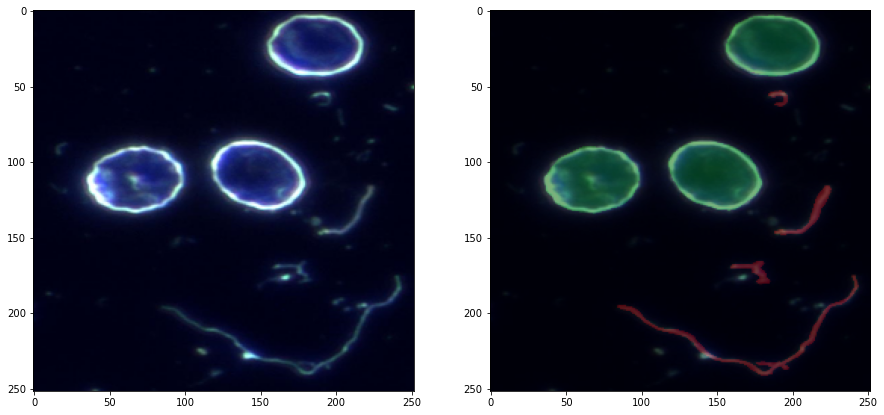

In [24]:
i = np.random.randint(0, len(data))
image, mask = data[i]

show_ann(image, mask)

# Step by step solution:

## 1. Get mask proposals

### 1.1. Use adaptative histogram equalization to highlight darker regions

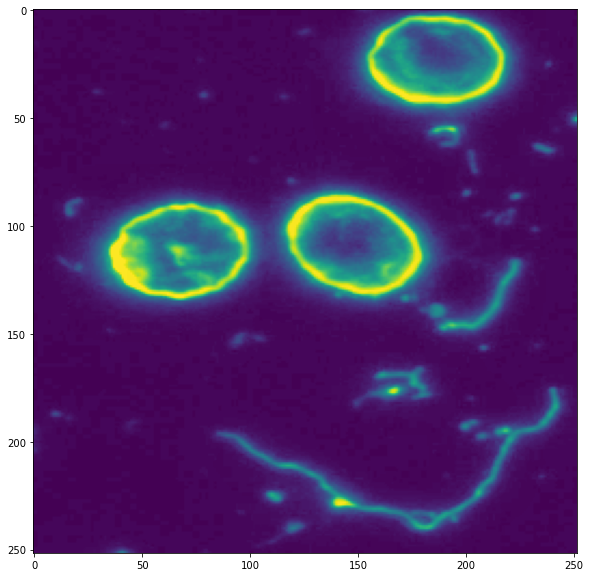

In [28]:
# define kernel
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

# augment contrast of objects in scene
lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
blur = equalize_adapthist(lab[...,0], clip_limit=0.01)
blur = np.uint8(blur*255)

plt.figure(figsize=(10,10))
plt.imshow(blur)

### 1.2. Use threshold OTSU to binary image

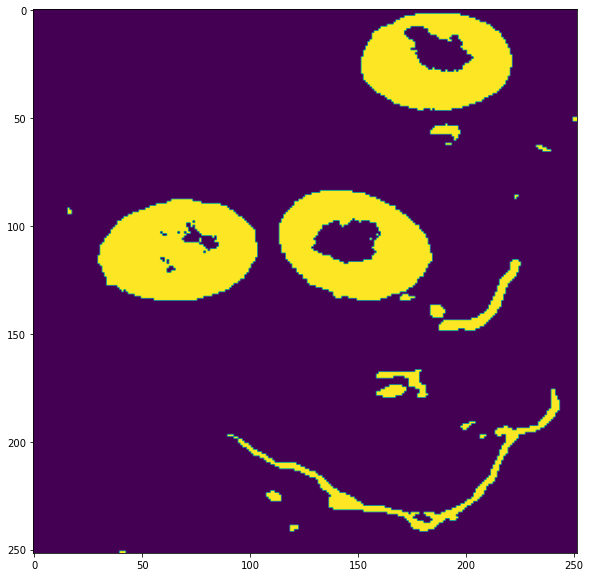

In [29]:
th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

plt.figure(figsize=(10,10))
plt.imshow(th)

### 1.3. Remove noises base on the contour features (perimeter<8)

Text(0.5, 1.0, 'After noise removal')

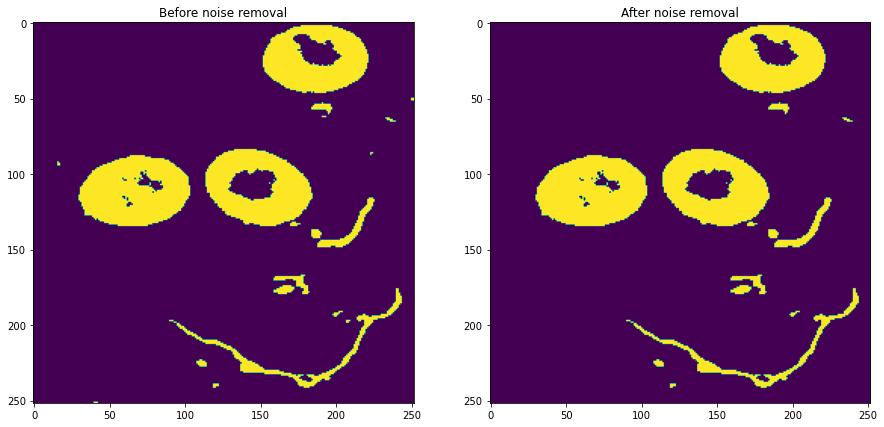

In [30]:
# remove noises
contour = cv2.findContours(th,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[1]
segmented = np.copy(th)
for cnt in contour:
    perimeter = cv2.arcLength(cnt,True)
    if perimeter>8:
        continue

    # remove noise
    draw = np.ones_like(segmented)
    cv2.drawContours(draw, [cnt], 0, (0,0,0), -1)

    segmented = segmented * draw
mask = np.uint8(segmented)

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(th)
plt.title('Before noise removal')
plt.subplot(122)
plt.imshow(mask)
plt.title('After noise removal')

### 1.4. Split thin regions

#### 1.4.1. Use a erosion and dilation subtraction to get to masks: (1) sure ery; (2) unknown

- (1) sure ery refers to segments more possible to be from ery class
- (2) unknown refers to segments that are unknown to which class it refers to

Text(0.5, 1.0, 'unknown')

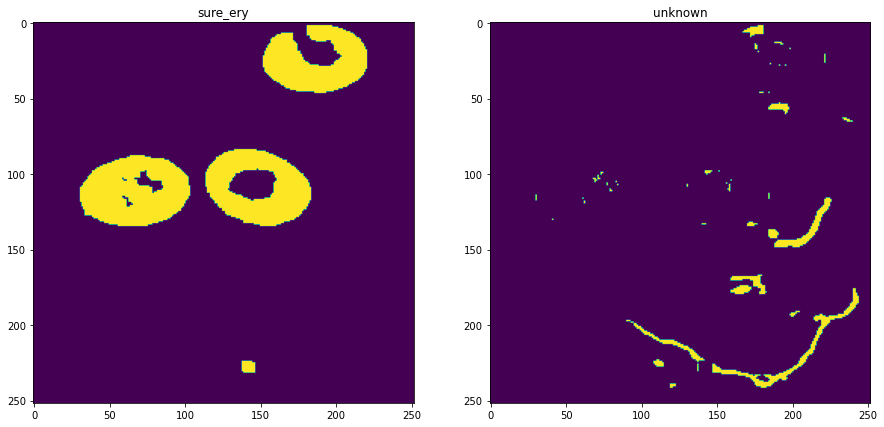

In [32]:
# split possible ery x spi classes
kernel = np.ones((3,3),np.uint8)
unknown = cv2.erode(mask, kernel, iterations=3)
sure_ery = cv2.dilate(unknown, kernel, iterations=3)
    
# unknown labels
unknown = cv2.subtract(mask, sure_ery)

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(sure_ery)
plt.title('sure_ery')

plt.subplot(122)
plt.imshow(unknown)
plt.title('unknown')

#### 1.4.2. Remove noises from the unknown regions mask

Text(0.5, 1.0, 'After noise removal')

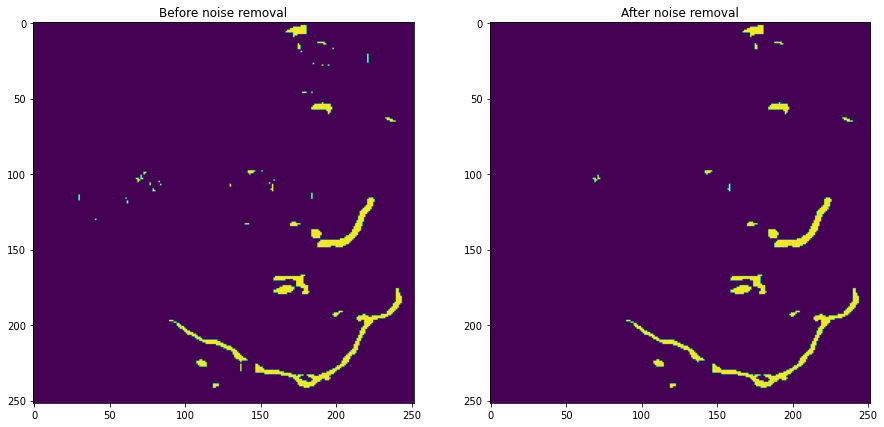

In [33]:
# probably spi
contour = cv2.findContours(unknown, cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)[1]
spi = np.zeros_like(sure_ery)
for cnt in contour:

    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt,True)
    if area<1 or perimeter<1:
        continue

    _ = cv2.drawContours(spi, [cnt], 0, 255, -1)

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(unknown)
plt.title('Before noise removal')
plt.subplot(122)
plt.imshow(spi)
plt.title('After noise removal')

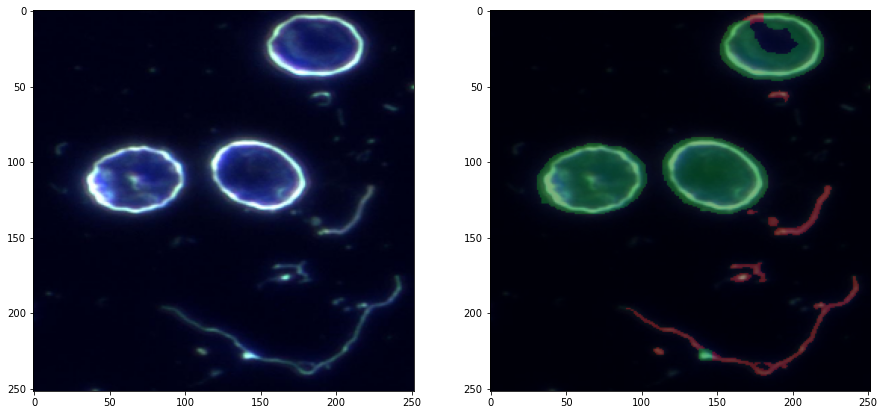

In [34]:
ery,spi = get_mask_proposal(image)
show_ann(image, np.stack([ery,spi], axis=-1))

## 2. Extract features from the masks

Using the Histogram of Oriented Gradients (HOG) to extract features from each mask.

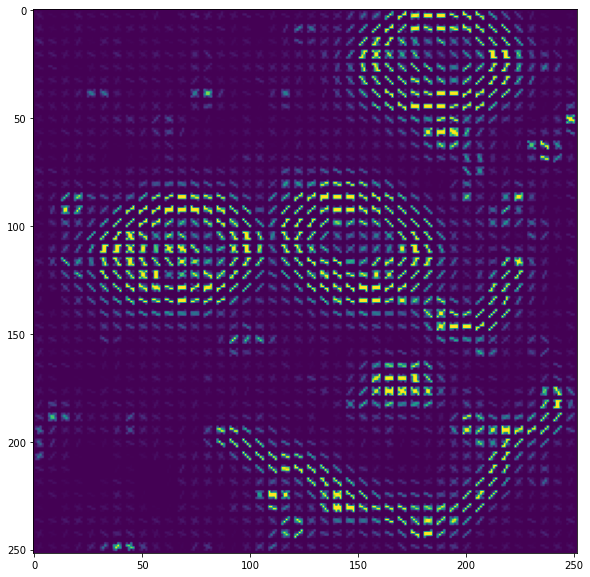

In [37]:
feats, hog_image = hog(image, orientations=8, pixels_per_cell=(6,6), 
                       cells_per_block=(1,1), visualize=True, multichannel=True)

# rescale histogram for better display
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))

plt.figure(figsize=(10,10))
plt.imshow(hog_image)

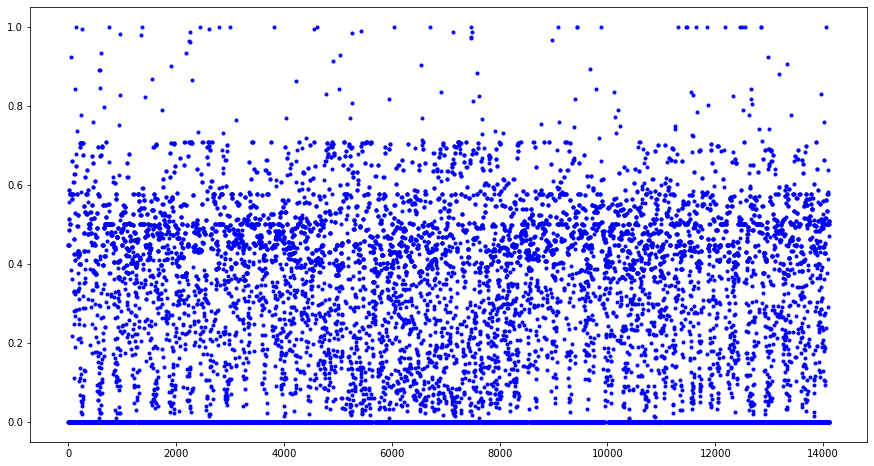

In [49]:
plt.figure(figsize=(15,8))
plt.plot(feats, 'b.')